In [1]:
from pytorch_ood.model import WideResNet
from tqdm import tqdm
import torch
import numpy as np

In [2]:
# fix ssl certificate issue
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# get device
def get_device():
    if torch.cuda.is_available():
        print("CUDA is available. Using GPU for computations.")
        return torch.device('cuda')
    else:
        print("CUDA is not available. Using CPU for computations.")
        return torch.device('cpu')

device = get_device()

# load model
model = WideResNet(num_classes=10, pretrained="cifar10-pt").to(device).eval()
print("Model loaded.")


import torchvision.transforms as trn
from pytorch_ood.utils import ToRGB
import torchvision.datasets as dset
from pytorch_ood.dataset.img import TinyImages300k
import pytorch_ood

def get_transforms(dataset_name, img_size=32):
    resize = trn.Resize((img_size, img_size))

    if dataset_name == "cifar10":
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]
    elif dataset_name == "cifar100":
        mean = [0.5071, 0.4865, 0.4409]
        std = [0.2673, 0.2564, 0.2762]
    elif dataset_name == "imagenet":
        transform = trn.Compose([
                trn.Resize(256),
                trn.CenterCrop(224),
                ToRGB(),
                trn.ToTensor(),
                trn.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        return transform, transform
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")

    transform = trn.Compose([
        trn.RandomHorizontalFlip(),
        trn.RandomCrop(img_size, padding=4),
        trn.ToTensor(),
        trn.Normalize(mean, std)
    ])

    test_transform = trn.Compose([
        trn.ToTensor(),
        trn.Normalize(mean, std),
        resize
    ])

    return transform, test_transform

def create_data_loader(data, batch_size, shuffle, num_workers=0, pin_memory=True):
    return torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=shuffle,
                                       num_workers=num_workers, pin_memory=pin_memory)


def prepare_data_loaders():
    train_transform, _ = get_transforms("cifar10",32)
    train_data_in = dset.CIFAR10('../datasets', train=True, transform=train_transform, download=True)

    train_data_out = TinyImages300k(root="../datasets", transform=train_transform,
                                        target_transform=pytorch_ood.utils.ToUnknown(), download=True)

    # Define data loaders
    train_loader_in = create_data_loader(train_data_in, 64, shuffle=False)
    train_loader_out = create_data_loader(train_data_out, 64, shuffle=False)

    return train_loader_in, train_loader_out


inlier_loader, outlier_loader = prepare_data_loaders()

CUDA is available. Using GPU for computations.
Model loaded.
Files already downloaded and verified


In [4]:
for in_set, out_set in tqdm(zip(inlier_loader, outlier_loader), total=len(inlier_loader)):
    # define variables
    inlier = in_set[0].to(device)
    outlier = out_set[0].to(device)
    # set requires_grad to true
    inlier.requires_grad = True
    outlier.requires_grad = True

    # define target
    target_inlier = in_set[1].to(device)
    target_outlier = out_set[1].to(device)

    images_concat = torch.cat((inlier, outlier), 0).to(device)
    outputs_complete = model(images_concat)
    energy_complete = -torch.logsumexp(outputs_complete, dim=1)

    for i in tqdm(range(1)):
        images_concat = torch.cat((inlier, outlier), 0).to(device)

        outputs_complete = model(images_concat)
        outputs = model(outlier)

        # Calculate energy
        energy = -torch.logsumexp(outputs, dim=1)


        # Calculate energy for inlier and outlier
        energy_inlier = energy_complete[:len(inlier)]
        energy_outlier = energy

        # calculate mean
        mean_inlier = torch.mean(energy_inlier)
        mean_outlier = torch.mean(energy_outlier)

        # print("mean inlier: ", mean_inlier)
        # print("mean outlier: ", mean_outlier)

        # Calculate gradients of model energy
        grad_energy = torch.autograd.grad(mean_outlier, outlier,
                                          retain_graph=False, create_graph=False)[0]

        new_outlier = outlier - 0.04 * torch.sign(grad_energy)
        adv_img = torch.cat((inlier, new_outlier), 0).to(device)

        outputs_adv = model(adv_img)

        energy_adv = -torch.logsumexp(outputs_adv, dim=1)[len(inlier):]


        # comparison with high eps
        new_outlier_high = outlier - 0.5 * torch.sign(grad_energy)
        adv_img_high  = torch.cat((inlier, new_outlier_high), 0).to(device)

        outputs_adv_high  = model(adv_img_high )

        energy_adv_high  = -torch.logsumexp(outputs_adv_high , dim=1)[len(inlier):]

    break


print(outlier[0])
print(new_outlier[0])


  0%|          | 0/782 [00:04<?, ?it/s]

tensor([[[-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         ...,
         [-0.8783, -0.4906, -0.0641,  ...,  0.3817, -2.4291, -2.4291],
         [-0.9946, -0.5293, -0.0060,  ...,  0.3236, -2.4291, -2.4291],
         [-0.6844, -0.1998,  0.2461,  ...,  0.2654, -2.4291, -2.4291]],

        [[-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         ...,
         [-0.8646, -0.8842, -1.1596,  ..., -1.3956, -2.4183, -2.4183],
         [-0.6482, -0.8842, -1.2776,  ..., -1.4742, -2.4183, -2.4183],
         [-0.6679, -1.1399, -1.4152,  ..., -1.5332, -2.4183, -2.4183]],

        [[-2.2214, -2.2214, -2.2214,  ..., -2.2214, -2.2214, -2.2214],
         [-2.2214, -2.2214, -2.2214,  ..., -2

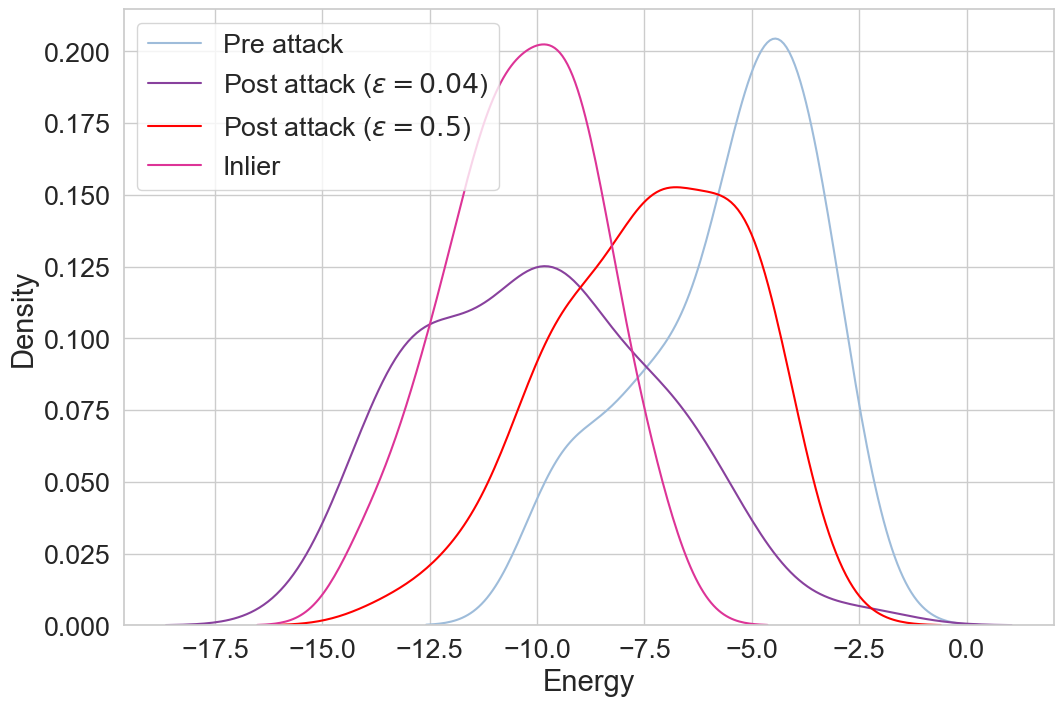

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.75)

data_pre = energy_outlier.detach().cpu().numpy()
data_post = energy_adv.detach().cpu().numpy()
data_post_high = energy_adv_high.detach().cpu().numpy()
data_inlier = energy_inlier.detach().cpu().numpy()

# Assuming you have data_pre and data_post as NumPy arrays

# Calculate the mean of data_pre and data_post
mean_pre = np.mean(data_pre)
mean_post = np.mean(data_post)
mean_inlier = np.mean(data_inlier)

# Create a figure and axis object
plt.figure(figsize=(12, 8))
# Create histograms using Seaborn
bins = 30
inlier_color = '#dd3497'#addd8e
# inlier_color = "#addd8e"
# sns.histplot(data_inlier, bins=bins, color=inlier_color, alpha=0.3, label="Inlier")
# sns.histplot(data_pre, bins=bins, color='#9ebcda', alpha=0.5, label="Pre attack")
# sns.histplot(data_post, bins=bins, color='#88419d', alpha=0.5, label="Post attack")

# kde plot
sns.kdeplot(data_pre, color='#9ebcda', alpha=1, label="Pre attack")
sns.kdeplot(data_post, color='#88419d', alpha=1, label="Post attack ($\\epsilon = 0.04$)")
sns.kdeplot(data_post_high, color='red', alpha=1, label="Post attack ($\\epsilon = 0.5$)")
sns.kdeplot(data_inlier, color=inlier_color, alpha=1, label="Inlier")

# Add average values to the plot
# plt.axvline(mean_pre, color='#9ebcda', linestyle='dashed', linewidth=2, label=f"Mean (pre attack)")
# plt.axvline(mean_post, color='#88419d', linestyle='dashed', linewidth=2, label=f"Mean (post attack)")
# plt.axvline(mean_inlier, color=inlier_color, linestyle='dashed', linewidth=2, label=f"Mean (inlier)")

plt.xlabel('Energy')
plt.ylabel('Density')
# plt.title('Histogram of Data')
plt.legend()
plt.grid(True)


# save as pdf
#plt.savefig(r"C:\Users\thbot\Desktop\UNIVERSITY\Master\Outlier Exposure WIP\Outlier new\Outlier-Exposure-Detection\evaluation\plots\energy_kde.pdf",bbox_inches='tight')

# Show the plot
plt.show()
